# Criando animação para mostrar o comportamente AC

In [1]:
import matplotlib
import matplotlib.pyplot as plt  # importar a bilioteca pyplot para fazer gráficos
from matplotlib import colors
import matplotlib.animation as animation
#---
import numpy as np   # importar a biblioteca Numpy para lidar com matrizes
import pandas as pd   # importa bilioteca pandas para  lidar com processamento de dados
import os
from scipy import optimize
#---
import SchemDraw as schem
import SchemDraw.elements as e
#---
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

In [2]:
def DivTensao(Z1, Z2, fonte = [True,e.SOURCE_V], unit_size = 2.5, **kwargs):
    d = schem.Drawing(unit=unit_size, **kwargs)
    if fonte[0]:
        #fonte
        gnd1 = d.add(e.GND)
        d.add(fonte[1], label='$V_{Th}$')
        d.add(e.RES, d='right', label='$R_g$')
    #divisor de tensão
    vin = d.add(e.DOT_OPEN ,label='$V_{in}$')
    z1 = d.add(Z1[0], d='right',label='${}$'.format(Z1[1]))
    z2 = d.add(Z2[0], d='down',botlabel='${}$'.format(Z2[1]))
    gnd2 = d.add(e.GND)
    #output
    d.add(e.LINE, d='right', xy=z1.end, l=1)
    vout = d.add(e.DOT_OPEN, label='$V_{out}$')
    #loop
    d.labelI(z2, '$I$',top=False, arrowofst = 0.8, arrowlen = 0.75)
    return d

In [3]:
def KVL(V,Vin,R):
    '''
    Função para definir a lei de Kirchhoff para os circuitos 
    que ser serão resolvidos neste notebook
    '''
    return Vin-R*Iv(V)-V
def Vi(Vin,V0,R):
    '''
    Função para resolver a KVL contendo o componente não-linear.
    Note que V0 definirá o intervalo de busca das
    raízes numéricas (do scipy.optimize.brentq).
    '''
    return optimize.brentq(KVL, -1.1*V0, 1.1*V0, args = (Vin,R))
def anima_curva_carga(nframes,movie_duration=10,ω=2*np.pi):
    '''
    Função para gerar graficos de curva de carga.
    *NOTA: Tive que alterar a classe do schemdraw para
    evitar redução sucessiva no tamanho do circuito desenhado!
    '''
    #----------------------------------------
    def init():  # only required for blitting to give a clean slate.
        nanvec = [np.nan] * len(tVec)
        for line in lines:
            line.set_data(nanvec,nanvec)
        return lines


    def animate(i):
        #----------
        #----------
        #Grafico 0
        Vlhs = VinVec[i]-R*Id # equação LHS
        #curva de carga
        l0b.set_data(Vlhs,Id*1e3)  # update the data.
        #ponto solucao da KVL
        l0c.set_data(VdVec[i],1e3*IdVec[i])  # update the data.
        l0c.set_c = cm(divnorm(IdVec[i]))
        #tensão de entrada
        l0d.set_data(VinVec[i],0)  # update the data.
        #l0e.set_data(0,1e3*VinVec[i]/R)  # update the data.
        #----------
        #----------
        #Grafico 1
        l1a.set_data(VdVec[i],tVec[i])  # update the data.
        l1b.set_data(VinVec[i],tVec[i])  # update the data.
        #----------
        #----------
        #Grafico 2
        l2a.set_data(tVec[i],1e3*IdVec[i])  # update the data. 
        #----------
        #----------
        #Grafico 3
        dschem.elements[1].segments[0].color = cm(divnorm(IdVec[i]))
        dschem.elements[2].segments[0].color = cm(divnorm(IdVec[i]))
        dschem.elements[2].segments[1].color = cm(divnorm(IdVec[i]))
        dschem.draw(ax=ax[1,1])   
        return lines
    #---------------------
    # nframes = 200 # number of animation V
    # ω=2*np.pi # frequencia angular
    tVec = np.linspace(0,2,nframes)
    VinVec = Vdc+V0*np.sin(ω*tVec)
    #--------------------------------------------------
    #--------------------------------------------------
    #solve diode equation for each input voltage
    VdVec = np.array([Vi(Vin,V0,R) for Vin in VinVec])
    IdVec = Iv(VdVec)
    #----
    Idmedio = np.mean(IdVec)
    Vdmedio = np.mean(VdVec)
    #range para os gráficos
    Irange = 1e3*np.array([np.min(IdVec),np.max(IdVec)]) + 0.5*1e3*np.array([-Idmedio,Idmedio])
    # Irange = np.round(Irange,3)
    Vrange = np.array([np.min(VinVec),np.max(VinVec)])+ 0.2*np.array([-V0,V0])
    # Irange = np.round(Vrange,2)
    #----
    #cores para os componentes
    divnorm = colors.Normalize(vmin = np.min(IdVec),vmax = np.max(IdVec))
    #--------------------------------------------------
    #--------------------------------------------------
    #GRAFICOS
    lines = []
    #--------------------------------------------------
    #Grafico 0: ax0 (superior esquerdo)
    #--------------------------------------------------
    #Equaçoes:
    ax0 = ax[0,0]
    V = np.linspace(min(Vrange),max(Vrange),5000)
    I = V/R
    Id = Iv(V)  # equação diodo
    Vlhs = Vdc-R*Id # equação LHS
    #legendas
    lab2 = r'$I= \frac{V_{in}-V_{out}}{R_1}$'
    lab3 = r'$V_{in}$'
    #Curva IxV do diodo - estática
    l0a, = ax0.plot(V,Id*1e3, 'r', label = lab1 ) # curva IxV diodo
    #Linhas verticais e horizontais (estáticas)
    ax0.axvline(np.max(VdVec),c='b',linestyle='--', alpha=alphahv,zorder=1)
    ax0.axvline(np.min(VdVec),c='b',linestyle='--', alpha=alphahv,zorder=2)
    ax0.axhline(1e3*np.max(IdVec),c='r',linestyle='--', alpha=alphahv,zorder=3)
    ax0.axhline(1e3*np.min(IdVec),c='r',linestyle='--', alpha=alphahv,zorder=4)
    #Animacoes:
    #Curva de carga
    l0b, = ax0.plot(Vlhs,I*1e3, label = lab2,zorder=5)
    #Pontos animados
    l0c, = ax0.plot(VdVec,tVec,'o',c='b',ms=10,zorder=6)
    l0d, = ax0.plot(VinVec,VinVec*0,'*', color='k',label = lab3,zorder=7)# V_{OpenCircuit}
    #l0e, = ax0.plot(0*Id,Id*1e3,'P', color='k',label = lab3)# I_{ShortCircuit}

    #linhas de origens dos eixos
    ax0.axvline(0,c='k',ls='-',lw=1.0)
    ax0.axhline(0,c='k',ls='-',lw=1.0)
    #Legenda
    ax0.legend(loc='center left')
    #grids e range
    ax0.set_xlim(Vrange)
    ax0.set_ylim(Irange)
    ax0.grid(True)
    ax0.set_ylabel('Corrente (mA)')
    ax0.set_xticklabels(())
    #--------
    #objetos que serão animados:
    lines.extend([l0b,l0c,l0d])
    #--------------------------------------------------
    #Grafico 1: ax0 (inferior esquerdo)
    #--------------------------------------------------
    ax0 = ax[1,0]
    #Graficando a curva de Vin x ϕ
    ax0.plot(VdVec,tVec,'-', color='r', label = r'$V_2(t)$')
    ax0.plot(VinVec,tVec,'--',alpha=0.8, label = r'$V_{in}(t)$')
    #--
    ax0.axvline(np.max(VdVec),c='b',linestyle='--', alpha=alphahv)
    ax0.axvline(np.min(VdVec),c='b',linestyle='--', alpha=alphahv)
    ax0.axvline(Vdc,c='g',linestyle='-.', alpha=alphahv,label =r'$V^{in}_{dc}$') # nivel dc Vin
    ax0.axvline(np.mean(VdVec),c='r',linestyle='--', alpha=alphahv,label =r'$V^{out}_{dc}$') # nivel dc Vd
    ax0.legend(loc='upper right')
    #--
    ax0.axvline(0,c='k',ls='-',lw=1.0)
    #---
    l1a, = ax0.plot(VdVec,tVec,'o',c='b',ms=10, label = '$V$={:2g} mV'.format(1e3))
    l1b, = ax0.plot(VinVec,tVec,'*', color='k',ms=10,label = '$V$={:2g} mV'.format(1e3))
    #ax0.set_ylim([0,np.max()])
    ax0.set_xlim(Vrange)
    ax0.grid(True)
    ax0.set_ylabel('Tempo (s)')
    ax0.set_xlabel('Tensão (V)')
    #--------
    #objetos que serão animados:
    lines.extend([l1a,l1b])
    #--------------------------------------------------
    #--------------------------------------------------
    #Grafico 2: ax0 (superior direito)
    #--------------------------------------------------
    ax0 = ax[0,1]
    #Graficando a curva de Id x tempo
    ax0.plot(tVec,1e3*IdVec,'-', label = r'$I(V)$')
    ax0.axhline(1e3*np.max(IdVec),c='r',linestyle='--', alpha=alphahv)
    ax0.axhline(1e3*np.min(IdVec),c='r',linestyle='--', alpha=alphahv)
    ax0.axhline(0,c='k',ls='-',lw=1.0)
    #ax0.axhline(1e3*IdVec[0],c='g',linestyle='--', alpha=alphahv)
    l2a, = ax0.plot(tVec,1e3*IdVec,'o',c='b',ms=10)
    ax0.set_ylim(Irange)
    ax0.grid(True)
    ax0.legend(loc='upper right')
    ax0.set_xticklabels(())
    ax0.set_yticklabels(())
    #objetos que serão animados:
    lines.extend([l2a])
    #--------------------------------------------------
    #--------------------------------------------------
    ax0 = ax[1,1]
    #--------------------------------------------------
    #Graficando circuit
    dschem = DivTensao(c1,c2,fonte = [False,e.SOURCE_V],unit_size=5)
    dschem.draw(ax=ax0)
    # ax[1,1].set_aspect('equal', adjustable='box')
    ax0.axes.get_xaxis().set_visible(False)
    ax0.axes.get_yaxis().set_visible(False)
    ax0.set_frame_on(False)
    ax0.set_xticklabels(())
    ax0.set_yticklabels(())
    ax0.get_figure().set_size_inches(fig_size[0],fig_size[1])
    #--------------------------------------------------
    #--------------------------------------------------
    st = fig.suptitle(plt_label)
    # shift subplots down:
    st.set_y(1.02)
    plt.subplots_adjust(hspace = .05, wspace = .05)
    plt.tight_layout()
    #--------------------------------------------------
    #--------------------------------------------------
    #Gerando animacão
    ani = animation.FuncAnimation(
        fig, animate, init_func=init, interval=2, blit=True, save_count=nframes)

    #Salvando resultado 
    ani.save(fname, writer='ffmpeg', dpi=150 ,
             fps=nframes/movie_duration)#,savefig_kwargs={'bbox_inches',[2,2]})

In [4]:
def plot_curva_carga():
    Id = Iv(V)  # equação diodo
    plt.plot(V,Id*1e3, 'k', label = '$I(V)$',zorder=1)
    #----------------------
    for Vin in np.linspace(VinMin,VinMax,5):
        #print(Vin)
        Vlhs = Vin-R*Id # equação LHS
        plt.plot(Vlhs,Id*1e3, label = r'$V_{in}$'+'={:2g} V'.format(round(Vin,4)),zorder=2)
        #-----------
        #solução numérica da equação
        Vd = Vi(Vin,Vin,R)
        plt.scatter(Vd,1e3*Iv(Vd), color='r', marker='o', s=100,zorder=3)
    #     plt.axvline(Vd, color='k', linestyle = '--')
    #     plt.axhline(1e3*Iv(Vd), color='k', linestyle = '--')
    #-----------------------
    #plt.title('Curvas de carga  variando $V_{in}$')
    ax.axvline(0,c='k',ls='-',lw=1.5)
    ax.axhline(0,c='k',ls='-',lw=1.5)
    plt.xlabel('Tensão (V)')
    plt.ylabel('Corrente (mA)')
    plt.xlim([np.min(V),np.max(V)])
    plt.ylim([VinMin/R*1e3,VinMax/R*1e3])
    plt.legend(loc = 'center left',bbox_to_anchor=[1.0,0.5])
    plt.grid(True)
    plt.savefig(fname+'.pdf',bbox_inches='tight')

In [5]:
#Comandos opcionais para formatar gráfico
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}	
lines = {'linewidth' : 4.0}
matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)
#matplotlib.rc('figure', **figure)
cm = plt.get_cmap('hot')
color_list = [(0, 0, 0), (1, 0, 0)]
cm = colors.LinearSegmentedColormap.from_list(
        'preto-vermelho', color_list, N=50)
#------
fig_size = (14,10)

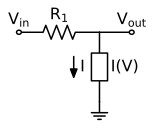

In [6]:
d = DivTensao([e.RES,'R_1'],[e.RBOX,'I(V)'],fonte = [False,e.SOURCE_V])
d.draw()
d.save('schem_divisor_IV.pdf')

# Resistor

## Resistor Ohmico

In [7]:
#----------------------
def Iv(V):
    '''
    Função que define a relação I(V) para o componente não-linear
    Componente: resistor de 100 Ω
    '''
    return (V)/100

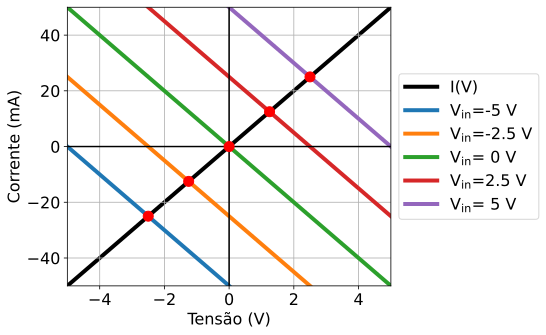

In [8]:
fname = 'resistor_ohmico'
fig,ax = plt.subplots(figsize=(5,5))
#Valores numéricos
R = 100 # resistencia R
Vin = 1 #Tensão de entrada
VinMin, VinMax = -5, 5 #limites do parâmetro de varredura
V = np.linspace(-5,5,100)
#---
plot_curva_carga()

AttributeError: 'Drawing' object has no attribute 'elements'

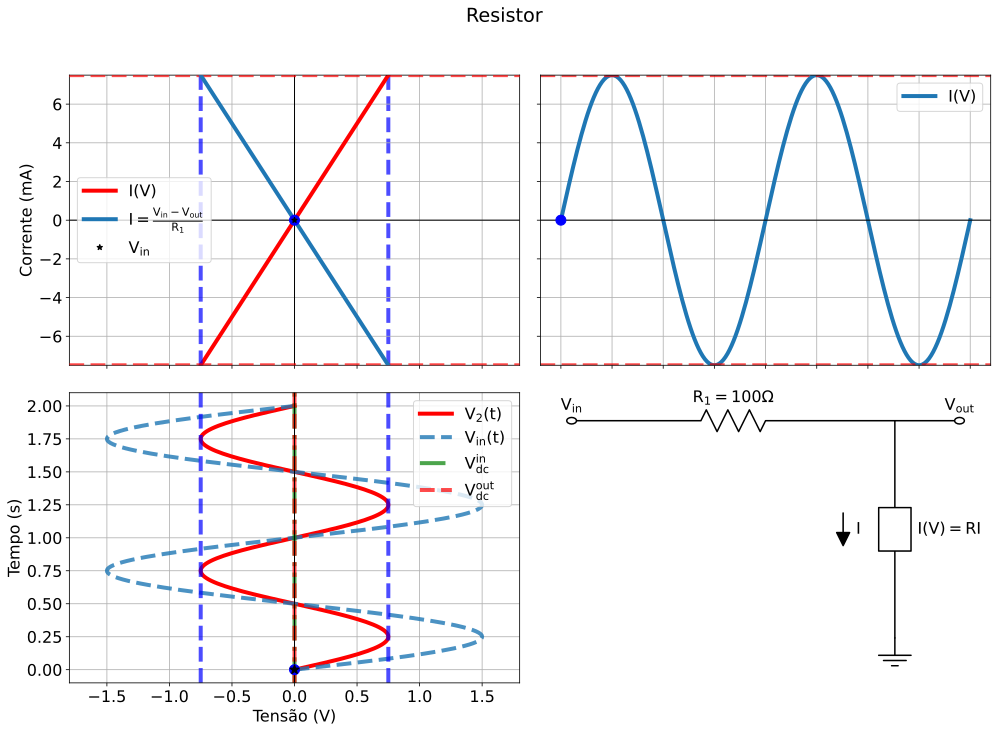

In [9]:
#---------------------
fig_size = (14,10)
fig,ax = plt.subplots(2, 2, figsize = fig_size)
alphahv = 0.7
#---------------------
#Parâmetros numéricos
R = 100 # resistencia R1
Vdc, V0 = 0, 1.5 # nível DC, amplitude
fname = 'resistor_V0_{:}_Vdc_{:}'.format(V0,Vdc).replace('.','p')+'.mp4'
plt_label = "Resistor"
c1 = [e.RES,'R_1={:}Ω'.format(R)]
c2 = [e.RBOX,'I(V)=RI']
lab1 = r'$I(V)$'
anima_curva_carga(200)

## Resistor não-linear

In [93]:
#----------------------
def Iv(V):
    '''
    Função que define a relação I(V) para o componente não-linear
    Componente: resistor de 100 Ω
    '''
    return (V+0.05*V**3 )/100

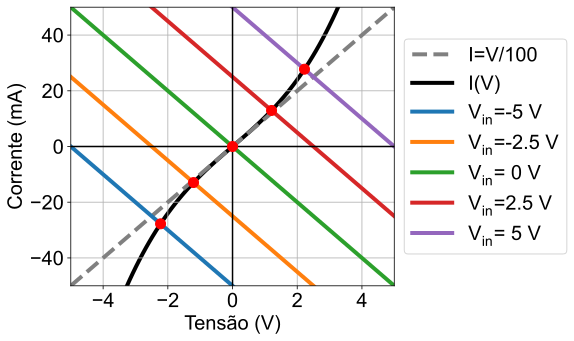

In [95]:
fname = 'resistor_não_ohmico'
fig,ax = plt.subplots(figsize=(5,5))
#Valores numéricos
R = 100 # resistencia R
Vin = 1 #Tensão de entrada
VinMin, VinMax = -5, 5 #limites do parâmetro de varredura
V = np.linspace(-5,5,100)
#---
ax.plot(V,1e3*V/100,'--',c='gray',label='I=V/100')
plot_curva_carga()


# Diodos

## Diodo idealizado (Vc=0)

In [128]:
#----------------------
def Iv(V):
    '''
    Função que define a relação I(V) para o componente não-linear
    Componente: diodo idealizado
    '''
    Vc=0 # tensao de cotovelo
    Rd=1 # resistência Ω, para V>Vc
    Vout = np.piecewise(V, [V < Vc, V >= Vc], [0, lambda V: (V-Vc)/Rd])
    return Vout

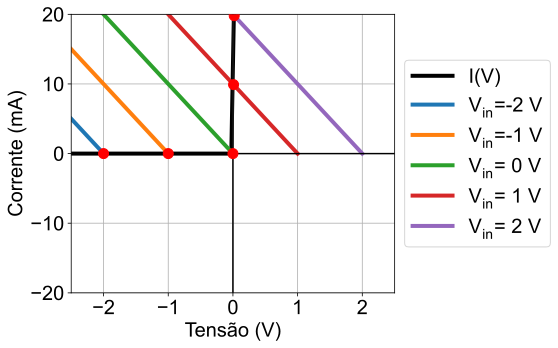

In [98]:
fname = 'diodo_ideal_Vc=0'
fig,ax = plt.subplots(figsize=(5,5))
#Valores numéricos
R = 100 # resistencia R
Vin = 1 #Tensão de entrada
VinMin, VinMax =-2, 2 #limites do parâmetro de varredura
V = np.linspace(-2.5,2.5,100)
#---
plot_curva_carga()

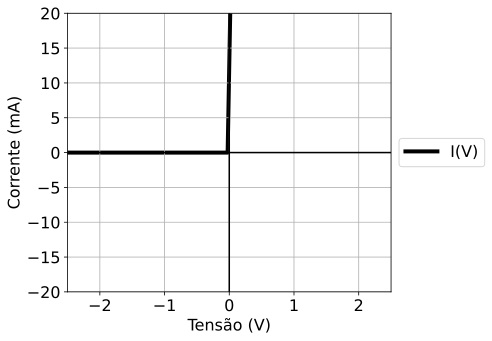

In [132]:
fig,ax = plt.subplots(figsize=(5,5))
#Valores numéricos
R = 100 # resistencia R
Vin = 1 #Tensão de entrada
VinMin, VinMax =-2, 2 #limites do parâmetro de varredura
V = np.linspace(-2.5,2.5,100)
Id = Iv(V)  # equação diodo
plt.plot(V,Id*1e3, 'k', label = '$I(V)$',zorder=1)
#----------------------
#-----------------------
#plt.title('Curvas de carga  variando $V_{in}$')
ax.axvline(0,c='k',ls='-',lw=1.5)
ax.axhline(0,c='k',ls='-',lw=1.5)
plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (mA)')
plt.xlim([np.min(V),np.max(V)])
plt.ylim([VinMin/R*1e3,VinMax/R*1e3])
plt.legend(loc = 'center left',bbox_to_anchor=[1.0,0.5])
plt.grid(True)
plt.savefig(fname+'.pdf',bbox_inches='tight')

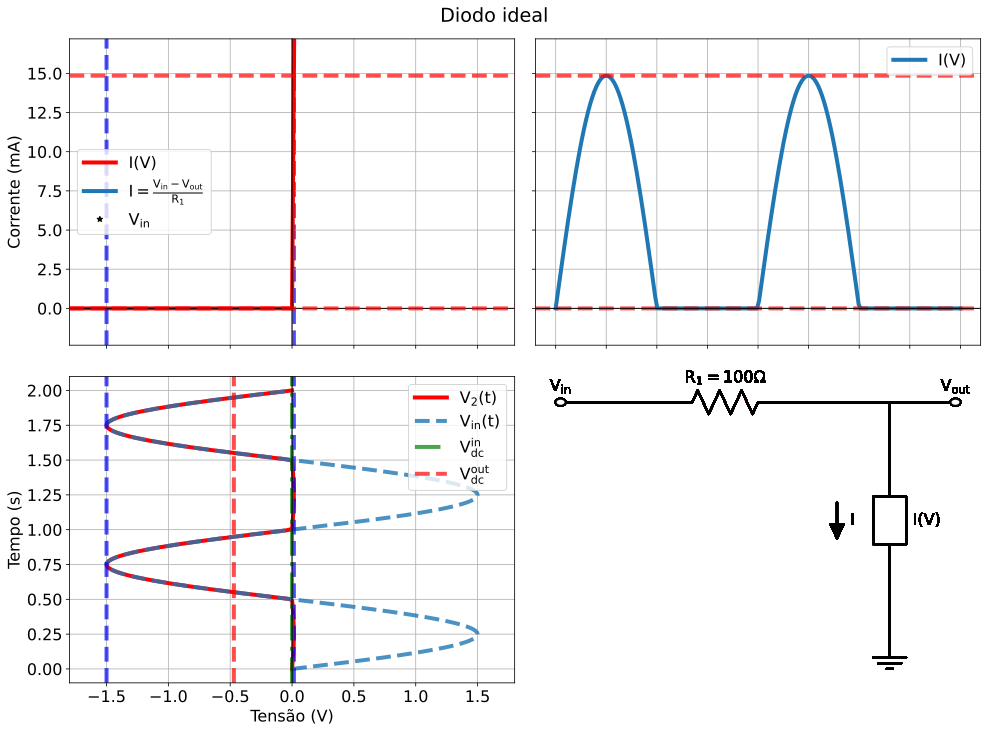

In [14]:
#---------------------
fig_size = (14,10)
fig,ax = plt.subplots(2, 2, figsize = fig_size)
alphahv = 0.7
#---------------------
#Parâmetros numéricos
R = 100 # resistencia R
Rd = 100

Vdc, V0 = 0, 1.5 # nível DC, amplitude
fname = 'diodo_ideal_Vc_0p0_V0_{:}_Vdc_{:}'.format(V0,Vdc).replace('.','p')+'.mp4'
plt_label = "Diodo ideal"
c1 = [e.RES,'R_1=100Ω']
c2 = [e.RBOX,'I(V)']
lab1 = r'$I(V)$'
anima_curva_carga(200)

## Diodo idealizado (Vc=0.6)

In [159]:
#----------------------
def Iv(V):
    '''
    Função que define a relação I(V) para o componente não-linear
    Componente: diodo idealizado
    '''
    Vc=0.6 # tensao de cotovelo
    Rd=1 # resistência Ω, para V>Vc
    Vout = np.piecewise(V, [V < Vc, V >= Vc], [0, lambda V: (V-Vc)/Rd])
    return Vout

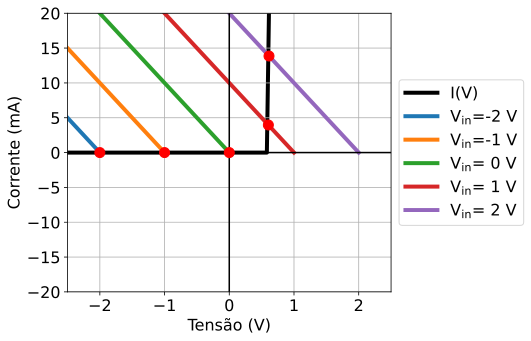

In [138]:
fname = 'diodo_ideal_Vc=0.6'
fig,ax = plt.subplots(figsize=(5,5))
#Valores numéricos
R = 100 # resistencia R
Vin = 1 #Tensão de entrada
VinMin, VinMax =-2, 2 #limites do parâmetro de varredura
V = np.linspace(-2.5,2.5,100)
#---
plot_curva_carga()

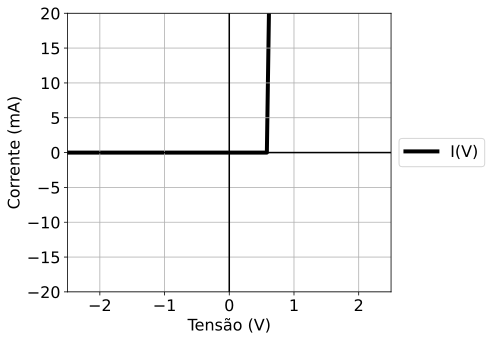

In [139]:
fig,ax = plt.subplots(figsize=(5,5))
#Valores numéricos
R = 100 # resistencia R
Vin = 1 #Tensão de entrada
VinMin, VinMax =-2, 2 #limites do parâmetro de varredura
V = np.linspace(-2.5,2.5,100)
Id = Iv(V)  # equação diodo
plt.plot(V,Id*1e3, 'k', label = '$I(V)$',zorder=1)
#----------------------
#-----------------------
#plt.title('Curvas de carga  variando $V_{in}$')
ax.axvline(0,c='k',ls='-',lw=1.5)
ax.axhline(0,c='k',ls='-',lw=1.5)
plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (mA)')
plt.xlim([np.min(V),np.max(V)])
plt.ylim([VinMin/R*1e3,VinMax/R*1e3])
plt.legend(loc = 'center left',bbox_to_anchor=[1.0,0.5])
plt.grid(True)
plt.savefig(fname+'_onlyIV'+'.pdf',bbox_inches='tight')

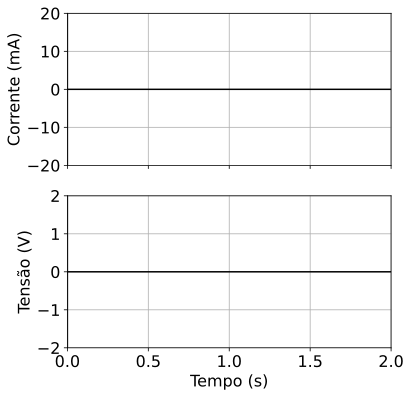

In [155]:
fig,axs = plt.subplots(2,1,figsize=(5,6),sharex=True)
#Valores numéricos
R = 100 # resistencia R
Vin = 1 #Tensão de entrada
VinMin, VinMax =-1, 1 #limites do parâmetro de varredura
V = np.linspace(-2.5,2.5,100)
#Id = Iv(V)  # equação diodo
#plt.plot(V,Id*1e3, 'k', label = '$I(V)$',zorder=1)
#----------------------
#-----------------------
ax=axs[0]
#plt.title('Curvas de carga  variando $V_{in}$')
ax.axvline(0,c='k',ls='-',lw=1.5)
ax.axhline(0,c='k',ls='-',lw=1.5)
ax.set_ylabel('Corrente (mA)')
#plt.xlabel('Tempo (s)')

ax.set_xlim([0,2])

ax.set_ylim([-20,20])
#plt.legend(loc = 'center left',bbox_to_anchor=[1.0,0.5])

ax.grid(True)
#-------
ax=axs[1]
#plt.title('Curvas de carga  variando $V_{in}$')
ax.axvline(0,c='k',ls='-',lw=1.5)
ax.axhline(0,c='k',ls='-',lw=1.5)

ax.set_ylabel('Tensão (V)')

ax.set_xlabel('Tempo (s)')

ax.set_xlim([0,2])

ax.set_ylim([-2,2])
#plt.legend(loc = 'center left',bbox_to_anchor=[1.0,0.5])

ax.grid(True)
plt.savefig('frame_plot_tensão_corrente'+'.pdf',bbox_inches='tight')

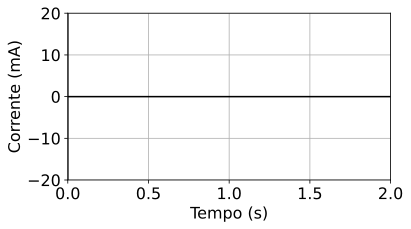

In [148]:
fig,ax = plt.subplots(figsize=(5,3))
#Valores numéricos
R = 100 # resistencia R
Vin = 1 #Tensão de entrada
VinMin, VinMax =-1, 1 #limites do parâmetro de varredura
V = np.linspace(-2.5,2.5,100)
#Id = Iv(V)  # equação diodo
#plt.plot(V,Id*1e3, 'k', label = '$I(V)$',zorder=1)
#----------------------
#-----------------------
#plt.title('Curvas de carga  variando $V_{in}$')
ax.axvline(0,c='k',ls='-',lw=1.5)
ax.axhline(0,c='k',ls='-',lw=1.5)
plt.ylabel('Corrente (mA)')
plt.xlabel('Tempo (s)')
plt.xlim([0,2])
plt.ylim([-20,20])
#plt.legend(loc = 'center left',bbox_to_anchor=[1.0,0.5])
plt.grid(True)
plt.savefig('frame_plot_corrente'+'.pdf',bbox_inches='tight')

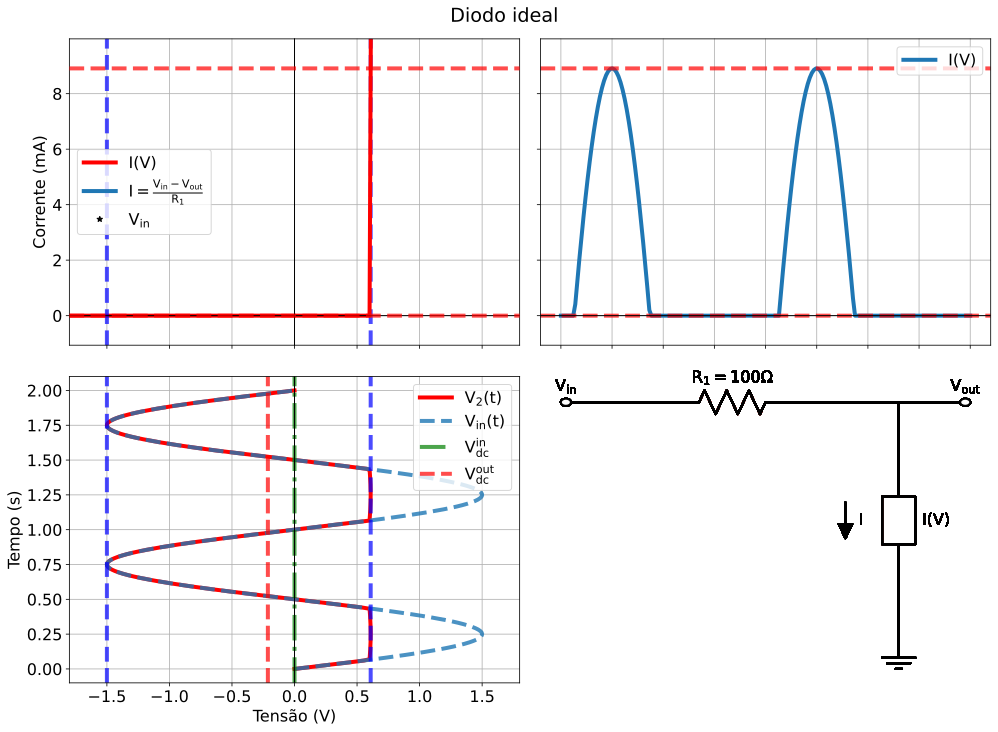

In [16]:
#---------------------
fig_size = (14,10)
fig,ax = plt.subplots(2, 2, figsize = fig_size)
alphahv = 0.7
#---------------------
#Parâmetros numéricos
R = 100 # resistencia R
Rd = 100

Vdc, V0 = 0, 1.5 # nível DC, amplitude
fname = 'diodo_ideal_Vc_0p6_V0_{:}_Vdc_{:}'.format(V0,Vdc).replace('.','p')+'.mp4'
plt_label = "Diodo ideal"
c1 = [e.RES,'R_1=100Ω']
c2 = [e.RBOX,'I(V)']
lab1 = r'$I(V)$'
anima_curva_carga(200)

In [175]:
def anima_curva_carga2(nframes,movie_duration=10,ω=2*np.pi):
    '''
    Função para gerar graficos de curva de carga.
    *NOTA: Tive que alterar a classe do schemdraw para
    evitar redução sucessiva no tamanho do circuito desenhado!
    '''
    #----------------------------------------
    def init():  # only required for blitting to give a clean slate.
        nanvec = [np.nan] * len(tVec)
        for line in lines:
            line.set_data(nanvec,nanvec)
        return lines


    def animate(i):
        #----------
        #----------
        #Grafico 0
        Vlhs = VinVec[i]-R*Id # equação LHS
        #curva de carga
        l0b.set_data(Vlhs,Id*1e3)  # update the data.
        #ponto solucao da KVL
        l0c.set_data(VdVec[i],1e3*IdVec[i])  # update the data.
        l0c.set_c = cm(divnorm(IdVec[i]))
        #tensão de entrada
        l0d.set_data(VinVec[i],0)  # update the data.
        #l0e.set_data(0,1e3*VinVec[i]/R)  # update the data.
        #----------
        #----------
        #Grafico 1
        l1a.set_data(VdVec[i],tVec[i])  # update the data.
        l1b.set_data(VinVec[i],tVec[i])  # update the data.
        l1c.set_data(R*IdVec[i],tVec[i])  # update the data.
        #----------
        #----------
        #Grafico 2
        l2a.set_data(tVec[i],1e3*IdVec[i])  # update the data. 
        #----------
        #----------
        #Grafico 3
        dschem.elements[1].segments[0].color = cm(divnorm(IdVec[i]))
        dschem.elements[2].segments[0].color = cm(divnorm(IdVec[i]))
        dschem.elements[2].segments[1].color = cm(divnorm(IdVec[i]))
        dschem.draw(ax=ax[1,1])   
        return lines
    #---------------------
    # nframes = 200 # number of animation V
    # ω=2*np.pi # frequencia angular
    tVec = np.linspace(0,2,nframes)
    VinVec = Vdc+V0*np.sin(ω*tVec)
    #--------------------------------------------------
    #--------------------------------------------------
    #solve diode equation for each input voltage
    VdVec = np.array([Vi(Vin,V0,R) for Vin in VinVec])
    IdVec = Iv(VdVec)
    #----
    Idmedio = np.mean(IdVec)
    Vdmedio = np.mean(VdVec)
    #range para os gráficos
    Irange = 1e3*np.array([np.min(IdVec),np.max(IdVec)]) + 0.5*1e3*np.array([-Idmedio,Idmedio])
    # Irange = np.round(Irange,3)
    Vrange = np.array([np.min(VinVec),np.max(VinVec)])+ 0.2*np.array([-V0,V0])
    # Irange = np.round(Vrange,2)
    #----
    #cores para os componentes
    divnorm = colors.Normalize(vmin = np.min(IdVec),vmax = np.max(IdVec))
    #--------------------------------------------------
    #--------------------------------------------------
    #GRAFICOS
    lines = []
    #--------------------------------------------------
    #Grafico 0: ax0 (superior esquerdo)
    #--------------------------------------------------
    #Equaçoes:
    ax0 = ax[0,0]
    V = np.linspace(min(Vrange),max(Vrange),5000)
    I = V/R
    Id = Iv(V)  # equação diodo
    Vlhs = Vdc-R*Id # equação LHS
    #legendas
    lab2 = r'$I= \frac{V_{in}-V_{out}}{R_1}$'
    lab3 = r'$V_{in}$'
    #Curva IxV do diodo - estática
    l0a, = ax0.plot(V,Id*1e3, 'r', label = lab1 ) # curva IxV diodo
    #Linhas verticais e horizontais (estáticas)
    ax0.axvline(np.max(VdVec),c='b',linestyle='--', alpha=alphahv,zorder=1)
    ax0.axvline(np.min(VdVec),c='b',linestyle='--', alpha=alphahv,zorder=2)
    ax0.axhline(1e3*np.max(IdVec),c='r',linestyle='--', alpha=alphahv,zorder=3)
    ax0.axhline(1e3*np.min(IdVec),c='r',linestyle='--', alpha=alphahv,zorder=4)
    #Animacoes:
    #Curva de carga
    l0b, = ax0.plot(Vlhs,I*1e3, label = lab2,zorder=5)
    #Pontos animados
    l0c, = ax0.plot(VdVec,tVec,'o',c='b',ms=10,zorder=6)
    l0d, = ax0.plot(VinVec,VinVec*0,'*', color='k',label = lab3,zorder=7)# V_{OpenCircuit}
    #l0e, = ax0.plot(0*Id,Id*1e3,'P', color='k',label = lab3)# I_{ShortCircuit}

    #linhas de origens dos eixos
    ax0.axvline(0,c='k',ls='-',lw=1.0)
    ax0.axhline(0,c='k',ls='-',lw=1.0)
    #Legenda
    ax0.legend(loc='center left')
    #grids e range
    ax0.set_xlim(Vrange)
    ax0.set_ylim(Irange)
    ax0.grid(True)
    ax0.set_ylabel('Corrente (mA)')
    ax0.set_xticklabels(())
    #--------
    #objetos que serão animados:
    lines.extend([l0b,l0c,l0d])
    #--------------------------------------------------
    #Grafico 1: ax0 (inferior esquerdo)
    #--------------------------------------------------
    ax0 = ax[1,0]
    #Graficando a curva de Vin x ϕ
    ax0.plot(VdVec,tVec,'-', color='r', label = r'$V_d(t)$')
    ax0.plot(VinVec,tVec,'--',alpha=0.8, label = r'$V_{in}(t)$')
    ax0.plot(R*IdVec,tVec,'-',c='m',ms=10, label = '$V_{out}(t)$')
    #--
    ax0.axvline(np.max(VdVec),c='b',linestyle='--', alpha=alphahv)
    ax0.axvline(np.min(VdVec),c='b',linestyle='--', alpha=alphahv)
    ax0.axvline(Vdc,c='g',linestyle='-.', alpha=alphahv,label =r'$V^{in}_{dc}$') # nivel dc Vin
    ax0.axvline(np.mean(VdVec),c='r',linestyle='--', alpha=alphahv,label =r'$V^{out}_{dc}$') # nivel dc Vd
    ax0.legend(loc='upper right')
    #--
    ax0.axvline(0,c='k',ls='-',lw=1.0)
    #---
    l1a, = ax0.plot(VdVec,tVec,'o',c='b',ms=10, label = '$V$={:2g} mV'.format(1e3))
    l1b, = ax0.plot(VinVec,tVec,'*', color='k',ms=10,label = '$V$={:2g} mV'.format(1e3))
    l1c, = ax0.plot(R*IdVec,tVec,'o',c='m',ms=10)
    #ax0.set_ylim([0,np.max()])
    ax0.set_xlim(Vrange)
    ax0.grid(True)
    ax0.set_ylabel('Tempo (s)')
    ax0.set_xlabel('Tensão (V)')
    #--------
    #objetos que serão animados:
    lines.extend([l1a,l1b,l1c])
    #--------------------------------------------------
    #--------------------------------------------------
    #Grafico 2: ax0 (superior direito)
    #--------------------------------------------------
    ax0 = ax[0,1]
    #Graficando a curva de Id x tempo
    ax0.plot(tVec,1e3*IdVec,'-', label = r'$I(V)$')
    ax0.axhline(1e3*np.max(IdVec),c='r',linestyle='--', alpha=alphahv)
    ax0.axhline(1e3*np.min(IdVec),c='r',linestyle='--', alpha=alphahv)
    ax0.axhline(0,c='k',ls='-',lw=1.0)
    #ax0.axhline(1e3*IdVec[0],c='g',linestyle='--', alpha=alphahv)
    l2a, = ax0.plot(tVec,1e3*IdVec,'o',c='b',ms=10)
    ax0.set_ylim(Irange)
    ax0.grid(True)
    ax0.legend(loc='upper right')
    ax0.set_xticklabels(())
    ax0.set_yticklabels(())
    #objetos que serão animados:
    lines.extend([l2a])
    #--------------------------------------------------
    #--------------------------------------------------
    ax0 = ax[1,1]
    #--------------------------------------------------
    #Graficando circuit
    dschem = DivTensao(c1,c2,fonte = [False,e.SOURCE_V],unit_size=5)
    dschem.draw(ax=ax0)
    # ax[1,1].set_aspect('equal', adjustable='box')
    ax0.axes.get_xaxis().set_visible(False)
    ax0.axes.get_yaxis().set_visible(False)
    ax0.set_frame_on(False)
    ax0.set_xticklabels(())
    ax0.set_yticklabels(())
    ax0.get_figure().set_size_inches(fig_size[0],fig_size[1])
    #--------------------------------------------------
    #--------------------------------------------------
    st = fig.suptitle(plt_label)
    # shift subplots down:
    st.set_y(1.02)
    plt.subplots_adjust(hspace = .05, wspace = .05)
    plt.tight_layout()
    #--------------------------------------------------
    #--------------------------------------------------
    #Gerando animacão
    ani = animation.FuncAnimation(
        fig, animate, init_func=init, interval=2, blit=True, save_count=nframes)

    #Salvando resultado 
    ani.save(fname, writer='ffmpeg', dpi=150 ,
             fps=nframes/movie_duration)#,savefig_kwargs={'bbox_inches',[2,2]})

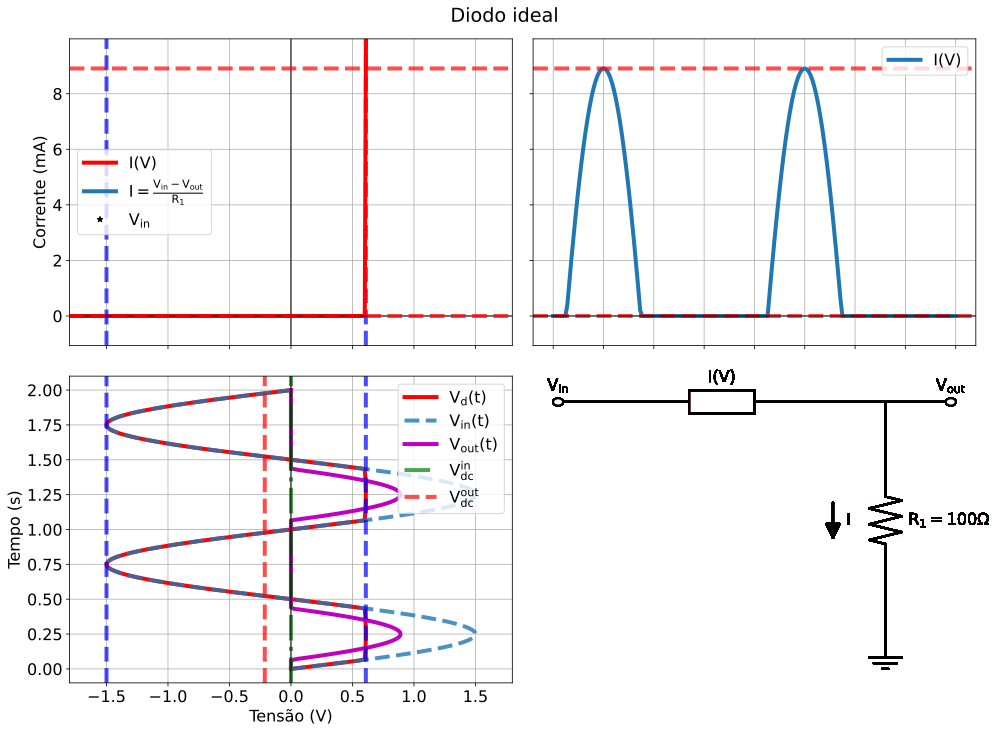

In [177]:
#---------------------
fig_size = (14,10)
fig,ax = plt.subplots(2, 2, figsize = fig_size)
alphahv = 0.7
#---------------------
#Parâmetros numéricos
R = 100 # resistencia R
Rd = 100

Vdc, V0 = 0, 1.5 # nível DC, amplitude
fname = 'diodo_ideal_res_Vc_0p6_V0_{:}_Vdc_{:}'.format(V0,Vdc).replace('.','p')+'.mp4'
plt_label = "Diodo ideal"
c2 = [e.RES,'R_1=100Ω']
c1 = [e.RBOX,'I(V)']
lab1 = r'$I(V)$'
anima_curva_carga2(200)

## Diodo real de Silicio (eq. Shockley)

In [156]:
#----------------------
def Iv(V,Is=1e-13):
    '''
    Função que define a relação I(V) para o componente não-linear
    Componente: diodo de Silicio Ω
    '''
    β, Is=39.6, 1e-13 #diodo de silício
    return Is*(np.exp(β*V)-1)

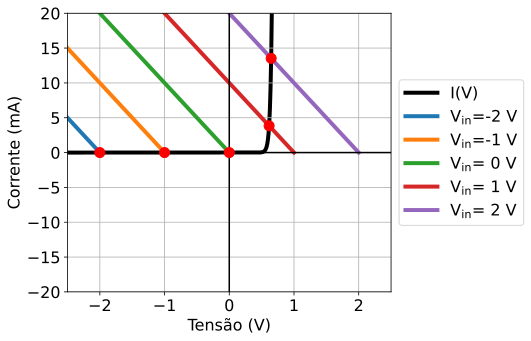

In [135]:
fname = 'diodo_real_Vc=0.6'
fig,ax = plt.subplots(figsize=(5,5))
#Valores numéricos
R = 100 # resistencia R
Vin = 1 #Tensão de entrada
VinMin, VinMax =-2, 2 #limites do parâmetro de varredura
V = np.linspace(-2.5,2.5,1000)
#---
plot_curva_carga()

In [157]:
#----------------------
def Iv(V,Is=1e-13):
    '''
    Função que define a relação I(V) para o componente não-linear
    Componente: diodo de Silicio Ω
    '''
    β, Is=39.6, 1e-13 #diodo de silício
    return Is*(np.exp(β*V)-1)

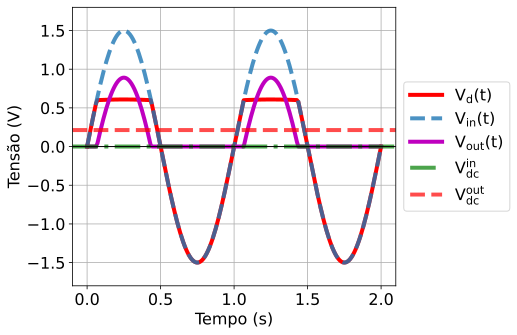

In [185]:
fname = 'diodo_real_Vc=0.6_V_vs_tempo'
fig,ax = plt.subplots(figsize=(5,5))
ω=2*np.pi
tVec = np.linspace(0,2,200)
VinVec = Vdc+V0*np.sin(ω*tVec)
#---------------
#solve diode equation for each input voltage
VdVec = np.array([Vi(Vin,V0,R) for Vin in VinVec])
IdVec = Iv(VdVec)
Vrvec = R*IdVec
#----
Idmedio = np.mean(IdVec)
Vdmedio = np.mean(VdVec)
#---------------
Irange = 1e3*np.array([np.min(IdVec),np.max(IdVec)]) + 0.5*1e3*np.array([-Idmedio,Idmedio])
# Irange = np.round(Irange,3)
Vrange = np.array([np.min(VinVec),np.max(VinVec)])+ 0.2*np.array([-V0,V0])
#---------------
#PLOT
ax0 = ax
#Graficando a curva de Vin x ϕ
ax0.plot(tVec,VdVec,'-', color='r', label = r'$V_d(t)$')
ax0.plot(tVec,VinVec,'--',alpha=0.8, label = r'$V_{in}(t)$')
ax0.plot(tVec,Vrvec,'-',c='m',ms=10, label = '$V_{out}(t)$')
#--
#ax0.axhline(np.max(VdVec),c='b',linestyle='--', alpha=alphahv)
#ax0.axhline(np.min(VdVec),c='b',linestyle='--', alpha=alphahv)
ax0.axhline(Vdc,c='g',linestyle='-.', alpha=alphahv,label =r'$V^{in}_{dc}$') # nivel dc Vin
ax0.axhline(np.mean(Vrvec),c='r',linestyle='--', alpha=alphahv,label =r'$V^{out}_{dc}$') # nivel dc Vd
ax0.legend(loc='center left',bbox_to_anchor=[1.0,0.5])
#--
ax0.axhline(0,c='k',ls='-',lw=1.0)
# #---
# l1a, = ax0.plot(VdVec,tVec,'o',c='b',ms=10, label = '$V$={:2g} mV'.format(1e3))
# l1b, = ax0.plot(VinVec,tVec,'*', color='k',ms=10,label = '$V$={:2g} mV'.format(1e3))
# l1c, = ax0.plot(R*IdVec,tVec,'o',c='m',ms=10)
#ax0.set_ylim([0,np.max()])
ax0.set_ylim(Vrange)
ax0.grid(True)
ax0.set_xlabel('Tempo (s)')
ax0.set_ylabel('Tensão (V)')
plt.savefig(fname+'.pdf',bbox_inches='tight')

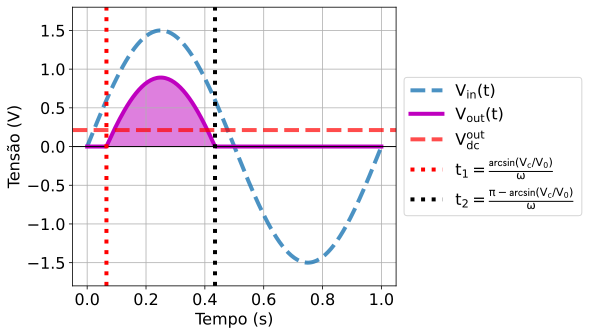

In [213]:
fname = 'diodo_real_Vc=0.6_V_vs_tempo_integral'
fig,ax = plt.subplots(figsize=(5,5))
ω=2*np.pi
tVec = np.linspace(0,1,200)
VinVec = Vdc+V0*np.sin(ω*tVec)
#---------------
#solve diode equation for each input voltage
VdVec = np.array([Vi(Vin,V0,R) for Vin in VinVec])
IdVec = Iv(VdVec)
VrVec = R*IdVec
#----
Idmedio = np.mean(IdVec)
Vdmedio = np.mean(VdVec)
#---------------
Irange = 1e3*np.array([np.min(IdVec),np.max(IdVec)]) + 0.5*1e3*np.array([-Idmedio,Idmedio])
# Irange = np.round(Irange,3)
Vrange = np.array([np.min(VinVec),np.max(VinVec)])+ 0.2*np.array([-V0,V0])
#---------------
#PLOT
ax0 = ax
#Graficando a curva de Vin x ϕ
#ax0.plot(tVec,VdVec,'-', color='r', label = r'$V_d(t)$')
ax0.plot(tVec,VinVec,'--',alpha=0.8, label = r'$V_{in}(t)$')
ax0.plot(tVec,VrVec,'-',c='m',ms=10, label = '$V_{out}(t)$')
#--
#ax0.axhline(np.max(VdVec),c='b',linestyle='--', alpha=alphahv)
#ax0.axhline(np.min(VdVec),c='b',linestyle='--', alpha=alphahv)
#ax0.axhline(Vdc,c='g',linestyle='-.', alpha=alphahv,label =r'$V^{in}_{dc}$') # nivel dc Vin
ax0.axhline(np.mean(Vrvec),c='r',linestyle='--', alpha=alphahv,label =r'$V^{out}_{dc}$') # nivel dc Vd

#--
ax0.axhline(0,c='k',ls='-',lw=1.0)
#----
Vc=0.6
t0 =  1/ω*(np.pi - np.arcsin(Vc/V0))
t1 =  1/ω*np.arcsin(Vc/V0)
ax0.axvline(t1,ls=':',c='r', label = r'$t_1=\frac{\arcsin(V_c/V_0)}{\omega}$')
ax0.axvline(t0,ls=':',c='k', label = r'$t_2=\frac{\pi-\arcsin(V_c/V_0)}{\omega}$')
# #---
# l1a, = ax0.plot(VdVec,tVec,'o',c='b',ms=10, label = '$V$={:2g} mV'.format(1e3))
# l1b, = ax0.plot(VinVec,tVec,'*', color='k',ms=10,label = '$V$={:2g} mV'.format(1e3))
# l1c, = ax0.plot(R*IdVec,tVec,'o',c='m',ms=10)
#ax0.set_ylim([0,np.max()])
ax0.set_ylim(Vrange)
ax0.grid(True)
ax0.set_xlabel('Tempo (s)')
ax0.set_ylabel('Tensão (V)')
ax0.fill_between(tVec,[0]*len(VrVec),VrVec,color='m',alpha=0.5)
ax0.legend(loc='center left',bbox_to_anchor=[1.0,0.5])
plt.savefig(fname+'.pdf',bbox_inches='tight')

In [195]:
np.mean(Vrvec)

0.21298121671442782

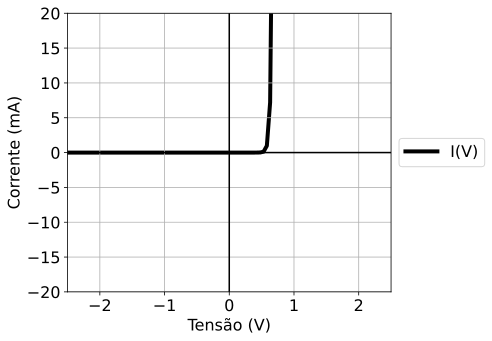

In [136]:
fig,ax = plt.subplots(figsize=(5,5))
#Valores numéricos
R = 100 # resistencia R
Vin = 1 #Tensão de entrada
VinMin, VinMax =-2, 2 #limites do parâmetro de varredura
V = np.linspace(-2.5,2.5,100)
Id = Iv(V)  # equação diodo
plt.plot(V,Id*1e3, 'k', label = '$I(V)$',zorder=1)
#----------------------
#-----------------------
#plt.title('Curvas de carga  variando $V_{in}$')
ax.axvline(0,c='k',ls='-',lw=1.5)
ax.axhline(0,c='k',ls='-',lw=1.5)
plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (mA)')
plt.xlim([np.min(V),np.max(V)])
plt.ylim([VinMin/R*1e3,VinMax/R*1e3])
plt.legend(loc = 'center left',bbox_to_anchor=[1.0,0.5])
plt.grid(True)
plt.savefig(fname+'_onlyIV'+'.pdf',bbox_inches='tight')

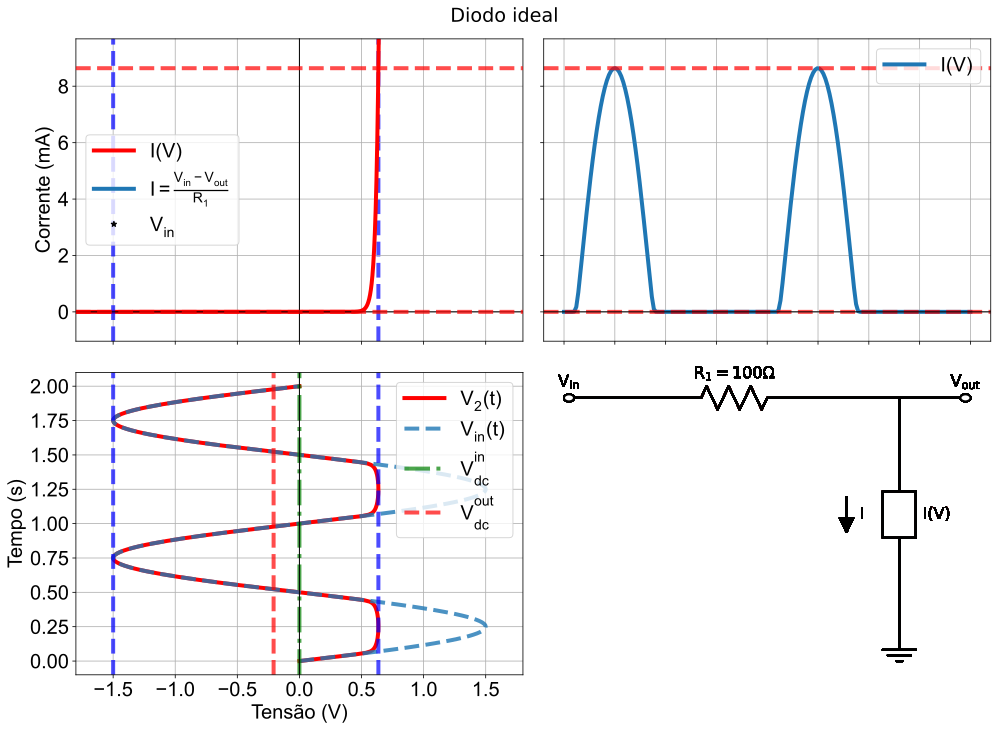

In [125]:
#---------------------
fig_size = (14,10)
fig,ax = plt.subplots(2, 2, figsize = fig_size)
alphahv = 0.7
#---------------------
#Parâmetros numéricos
R = 100 # resistencia R1
Vdc, V0 = 0, 1.5 # nível DC, amplitude
fname = 'diodo_real_V0_{:}_Vdc_{:}'.format(V0,Vdc).replace('.','p')+'.mp4'
plt_label = "Diodo ideal"
c1 = [e.RES,'R_1={:}Ω'.format(R)]
c2 = [e.RBOX,'I(V)']
lab1 = r'$I(V)$'
anima_curva_carga(200)